In [84]:
from cProfile import label
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.image as pmimg
import numpy as np
import nibabel as nib
import skimage.io as io
import skimage.transform as trans
import os.path
import copy
import cv2 as cv
import tensorflow as tf


# if true, reload and process data again, else load the data saved previously in files stored in numpy_arrays
# On a 30 * 30 abdomens + 20 * 30 labelisés au total
RELOAD_DATA = False
nb_dirs_to_load = 1000 # 50 folders total, bigger number means load all
nb_files_to_load_per_dir = 5 # putting a number bigger than the number of files will just load every file in the folder

# if true, retrain model
DO_WE_LEARN = True
epochs = 20
file_name = "model_transformer.hdf5"

approot = ""
try:
    approot = os.path.dirname(os.path.abspath(__file__))
except NameError: # We are in a jupyter notebook
    approot = os.getcwd()

# just going to data folder in order to load all dicom
os.chdir(str(approot))
print(str(approot))

d:\GitHub\abdomen_segmentation\single_organ_segmentation


In [85]:
# Fonctions utiles

# affichage d'image
def fast_display(img2dlst):
    plt.figure(figsize=(32, 12))
    nbImg = len(img2dlst)
    cols = min(6, nbImg)
    rows = (nbImg // cols) + 1
    for jaaj, img2d in enumerate(img2dlst):
        plt.subplot(rows, cols, jaaj + 1)
        plt.imshow(img2d)
    plt.show()

# affichage slice
def print_slices(img):
    disp_list = []
    for i in range(5, 60, 10):
        disp_list.append(img[i])
    fast_display(disp_list)

# affichage slice
def print_slices_inverted(img):
    disp_list = []
    for i in range(5, 60, 10):
        cpy = copy.deepcopy(img[i])
        cpy = np.swapaxes(cpy, 0, 2)
        cpy = np.swapaxes(cpy, 0, 1)
        disp_list.append(cpy)
    fast_display(disp_list)

# calcul des différences entre 2 images (dice)
def compute_dice(X, Y):
    Xbin = (X > 0)
    Ybin = (Y > 0)
    cardIntersec = np.sum(np.logical_and(Xbin, Ybin))
    cardX = np.sum(Xbin)
    cardY = np.sum(Ybin)
    print("cardIntersec = ", cardIntersec)
    print("cardX = ", cardX)
    print("cardY = ", cardY)
    if cardX + cardY > 0:
        dice = (2.0 * cardIntersec)/(cardX + cardY)
        print("dice = ", dice)
        return dice
    else:
        return 0

# normalisation des valeurs dans une image)
def normalize(img):
    m = np.mean(img[img > 0])
    s = np.std(img[img > 0])
    return np.clip((img - m) / (5 * s), -100, 100)

In [86]:
# Fonction de nettoyage des données, suppression des couches non labelisées, réduction de taille, léger découpage et normalisation
raw_data = []
labeled_data = []

def clean_and_save_data(scan, labeled_scan):
    global raw_data
    global labeled_data
    
    labeled_scan = np.where(labeled_scan == 6, 1, 0).astype('uint8')
    for i in range(scan.shape[2]):
        if labeled_scan[:, :, i].sum() == 0:
            continue
        
        resized_data         = cv.resize(scan[:, :, i], (scan.shape[0]//3, scan.shape[1]//3), cv.INTER_NEAREST)
        resized_data_labeled = cv.resize(labeled_scan[:, :, i], (labeled_scan.shape[0]//3, labeled_scan.shape[1]//3), cv.INTER_NEAREST)

        resized_data         = resized_data[5:resized_data.shape[0]-5, 29:resized_data.shape[1]-29]
        resized_data_labeled = resized_data_labeled[5:resized_data_labeled.shape[0]-5, 29:resized_data_labeled.shape[1]-29]

        resized_data = normalize(resized_data, )
        mask_img = np.where(resized_data > -1, 1, 0)
        resized_data_labeled = np.expand_dims(resized_data_labeled, axis=2)
        resized_data = np.expand_dims(resized_data, axis=2)
        mask_img = np.expand_dims(mask_img, axis=2)
        resized_data = np.append(resized_data, mask_img, axis=2)

        raw_data.append(resized_data)
        labeled_data.append(resized_data_labeled)

unique : [-5.9728785 -5.9681253 -5.9617662 ...  6.442156   6.4587812  6.467688 ]
Data shape  : (8967, 160, 112, 1)
Label shape : (8967, 160, 112, 1)
Raw data type     : float32
Labeled data type : uint8


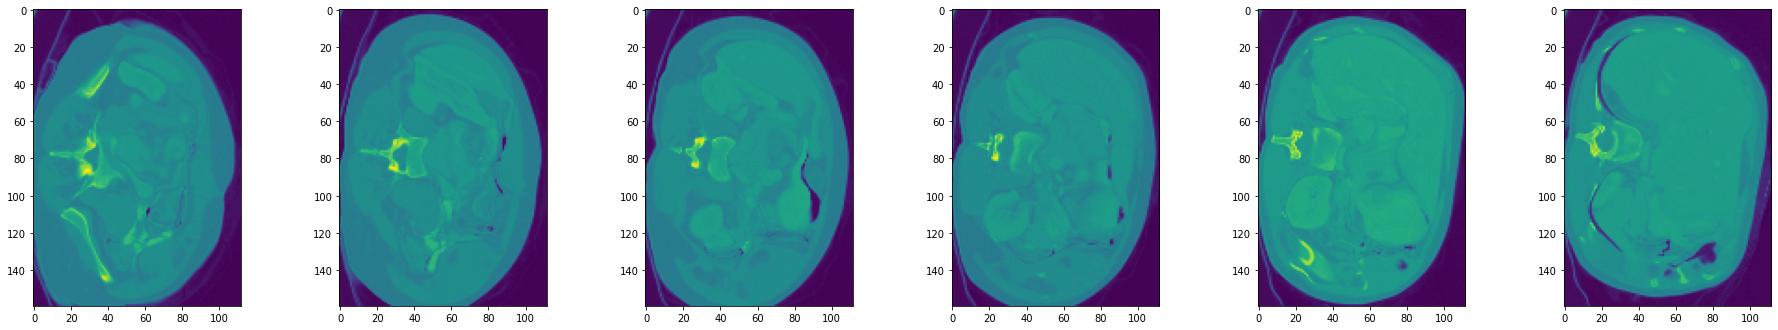

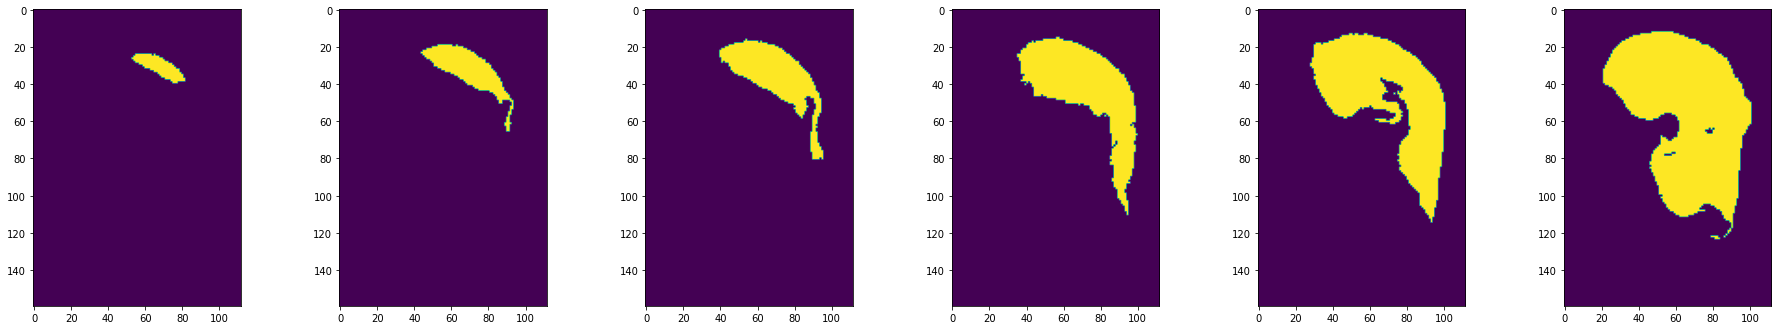

In [87]:
if RELOAD_DATA:
    loaded_dirs = 0
    for _, dirs, filenames in os.walk("../data/Training-Training/img"):
        for dir in dirs:

            loaded_dirs += 1
            if loaded_dirs > nb_dirs_to_load:
                break
            
            loaded_files = 0
            for _, dirs2, filenames2 in os.walk("../data/Training-Training/img/" + dir):
                for filename in filenames2:
                    if filename[0] == '.':
                        continue
                    
                    loaded_files += 1
                    if loaded_files > nb_files_to_load_per_dir:
                        break
                    
                    name = "../data/Training-Training/img/" + dir + "/" + filename
                    data = nib.load(name).get_fdata()
                    name_label = "../data/Training-Training/label/" + dir + "/" + "label" + filename[3:]
                    data_label = nib.load(name_label).get_fdata()
                    clean_and_save_data(data, data_label)

    raw_data = np.array(raw_data)
    labeled_data = np.array(labeled_data)
    raw_data = raw_data.astype('float32')
    labeled_data = labeled_data.astype('uint8')
    np.save("../numpy_arrays/raw_liver_data.npy", raw_data)
    np.save("../numpy_arrays/labeled_liver_data.npy", labeled_data)
else:
    raw_data = np.load("../numpy_arrays/raw_liver_data.npy")
    labeled_data = np.load("../numpy_arrays/labeled_liver_data.npy")

raw_data = np.expand_dims(raw_data[:, :, :, 0], axis=3)
print(f"unique : {np.unique(raw_data)}")
print("Data shape  : " + str(raw_data.shape))
print("Label shape : " + str(labeled_data.shape))
print('Raw data type     :', raw_data.dtype)
print('Labeled data type :', labeled_data.dtype)
print_slices(raw_data)
print_slices(labeled_data)

In [88]:
from att_unet import att_unet

_, sx, sy, sz = raw_data.shape

model = att_unet(sx, sy, n_label=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"]) # metrics can be changed as here : https://www.kaggle.com/code/firqaaa/attention-unet-for-pneumothorax-segmentation

xtrain shape      : (7173, 1, 160, 112)
ytrain shape      : (7173, 1, 160, 112)
xvalidation shape : (897, 1, 160, 112)
yvalidation shape : (897, 1, 160, 112)
xtest shape       : (897, 1, 160, 112)
ytest shape       : (897, 1, 160, 112)


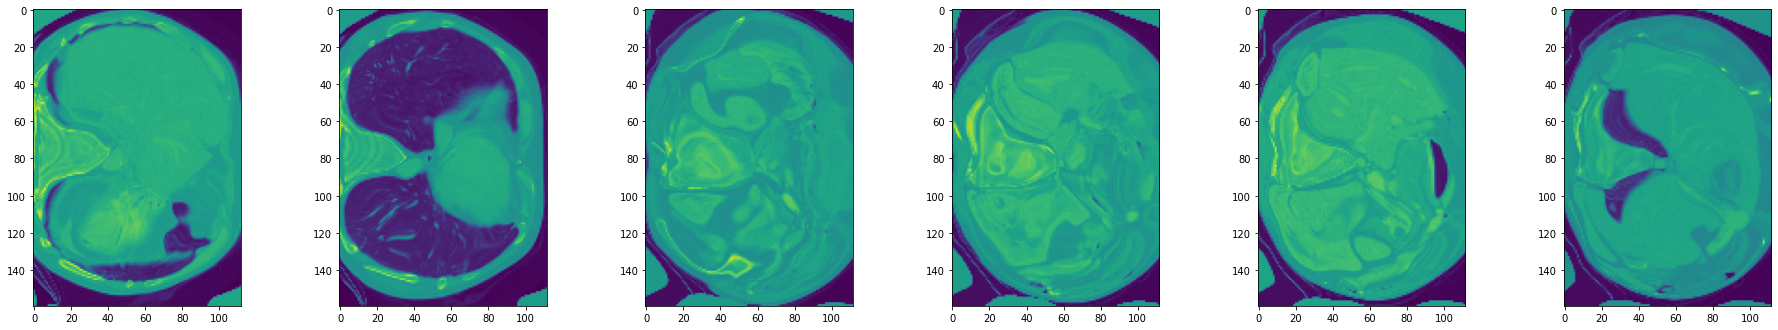

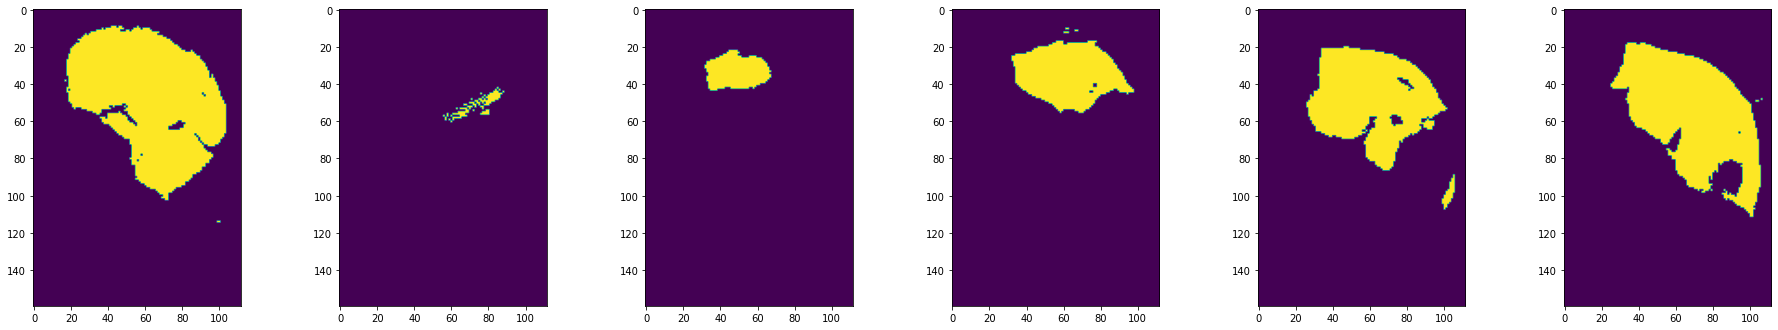

In [89]:
x, y = (0.8, 0.1) # split with x = 80%, y = 10% and therefore z = 10%
lenx = int(len(raw_data)*x)
leny = int(len(raw_data)*(x+y))

# switch channel
raw_data = np.rollaxis(raw_data, 3, 1)
labeled_data = np.rollaxis(labeled_data, 3, 1)

xtrain, xvalidation, xtest = np.split(raw_data, [lenx, leny])
ytrain, yvalidation, ytest = np.split(labeled_data, [lenx, leny])

print("xtrain shape      : " + str(xtrain.shape))
print("ytrain shape      : " + str(ytrain.shape))
print("xvalidation shape : " + str(xvalidation.shape))
print("yvalidation shape : " + str(yvalidation.shape))
print("xtest shape       : " + str(xtest.shape))
print("ytest shape       : " + str(ytest.shape))

print_slices_inverted(xtest)
print_slices_inverted(ytest)

In [90]:
# ---- entrainement ----

print("xtrain      : " + str(xtrain.shape))
print("ytrain      : " + str(ytrain.shape))
print("xvalidation : " + str(xvalidation.shape))
print("yvalidation : " + str(yvalidation.shape))

if DO_WE_LEARN:
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=2, mode='auto', baseline=None, restore_best_weights=True)

    history = model.fit(
    verbose = 1,
    initial_epoch = 0,
    x = xtrain,
    y = ytrain,
    batch_size = 32,
    validation_data = (xvalidation, yvalidation),
    epochs = epochs,
    callbacks = [early_stopping]
    )
    model.save_weights(file_name)
else:
    model.load_weights(file_name)

xtrain      : (7173, 1, 160, 112)
ytrain      : (7173, 1, 160, 112)
xvalidation : (897, 1, 160, 112)
yvalidation : (897, 1, 160, 112)
Epoch 1/20
225/225 [==============================] - 40s 170ms/step - loss: 0.1510 - accuracy: 0.0547 - val_loss: 0.1047 - val_accuracy: 0.0256
Epoch 2/20
225/225 [==============================] - 39s 171ms/step - loss: 0.0593 - accuracy: 0.0247 - val_loss: 0.0547 - val_accuracy: 0.0219
Epoch 3/20
225/225 [==============================] - 38s 169ms/step - loss: 0.0452 - accuracy: 0.0327 - val_loss: 0.0499 - val_accuracy: 0.0354
Epoch 4/20
225/225 [==============================] - 37s 166ms/step - loss: 0.0371 - accuracy: 0.0404 - val_loss: 0.0441 - val_accuracy: 0.0367
Epoch 5/20
225/225 [==============================] - 35s 157ms/step - loss: 0.0320 - accuracy: 0.0379 - val_loss: 0.0442 - val_accuracy: 0.0374
Epoch 6/20
225/225 [==============================] - 35s 156ms/step - loss: 0.0286 - accuracy: 0.0341 - val_loss: 0.0639 - val_accuracy: 0.0

In [91]:
prediction = model.predict(xtest)

29/29 [==============================] - 1s 41ms/step


(897, 1, 160, 112)
(897, 1, 160, 112)


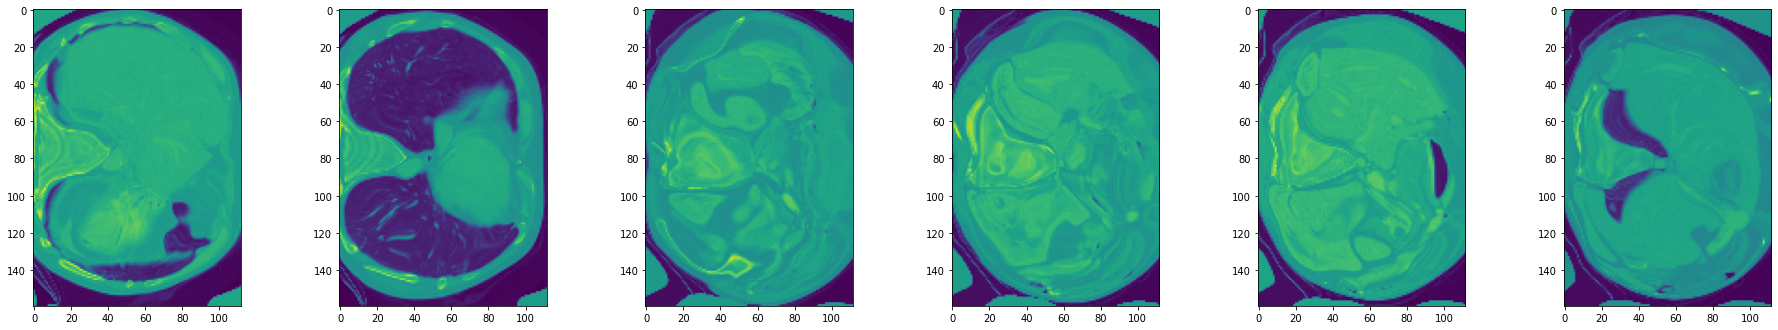

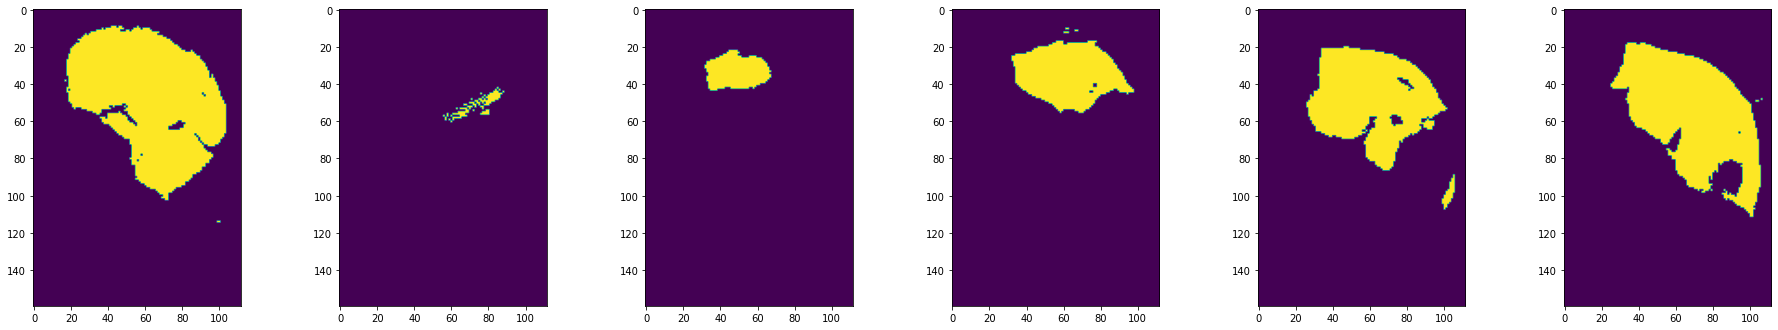

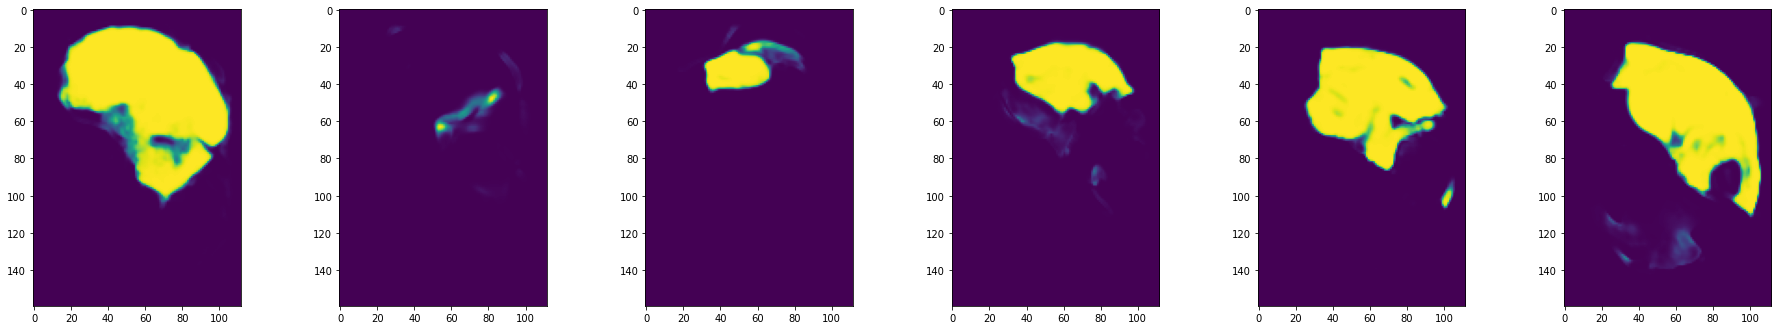

In [92]:
print(xtest.shape)
print(ytest.shape)
print_slices_inverted(xtest)
print_slices_inverted(ytest)
print_slices_inverted(prediction)

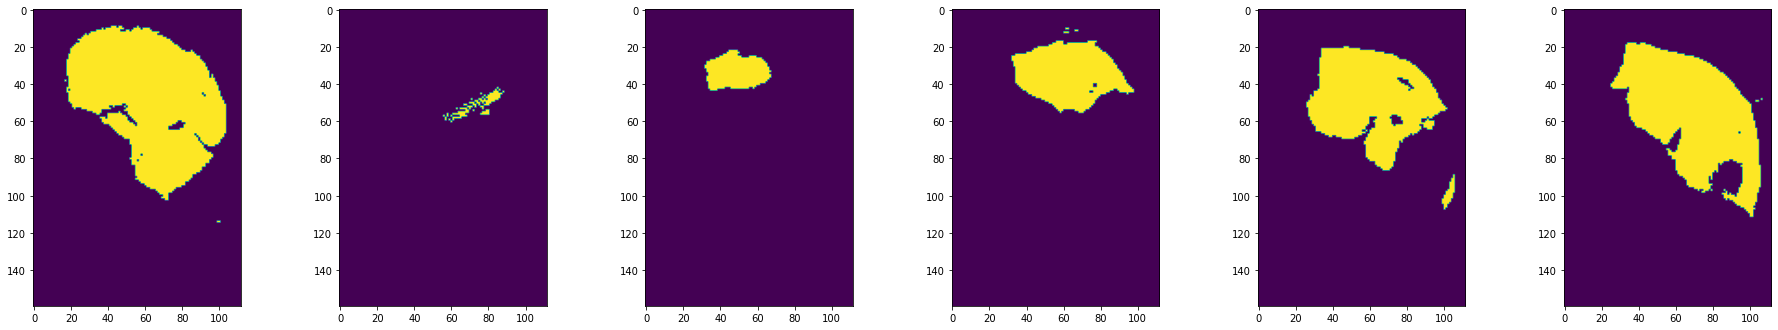

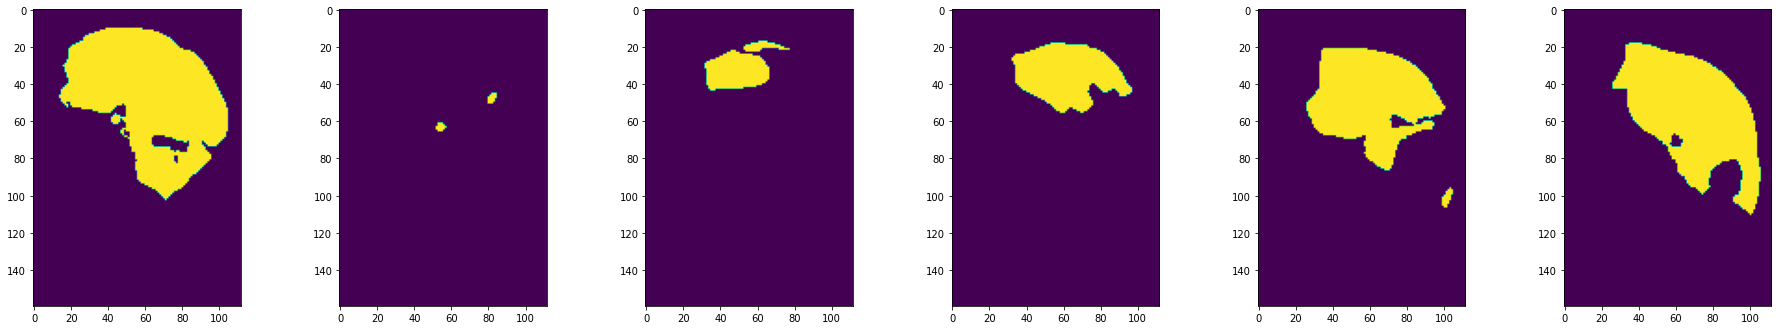

cardIntersec =  1151846
cardX =  1217460
cardY =  1338036
dice =  0.9014657037224868


In [93]:
rounded_prediction = np.round(prediction)

print_slices_inverted(ytest)
print_slices_inverted(rounded_prediction)

dice = compute_dice(rounded_prediction, ytest)